In [1]:
import uproot
import ROOT

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

Welcome to JupyROOT 6.14/02


In [6]:
import numpy as np

def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = np.array([tot.GetXaxis().GetBinCenter(i)                 for i in range(1, nBins+1)])
    yy = np.array([eff.GetEfficiency(eff.GetGlobalBin(i))         for i in range(1, nBins+1)])
    yl = np.array([eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) for i in range(1, nBins+1)])
    yu = np.array([eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i))  for i in range(1, nBins+1)])
    
    return {'x': xx,
            'y': yy,
            'yerr': np.array([yu, yl])}

In [13]:
 def extract_tprof(prof):
    nBins = prof.GetNbinsX()
    xx  = np.array([prof.GetXaxis().GetBinCenter(i) for i in range(1, nBins+1)])
    yy  = np.array([prof.GetBinContent(i)           for i in range(1, nBins+1)])
    err = np.array([prof.GetBinError(i)             for i in range(1, nBins+1)])
    
    return {'x': xx,
            'y': yy,
            'yerr': err} 

In [2]:
# tree = uproot.open('../Firefighter/washAOD/test/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2_100k.root')['RECO_muTrackEffi/recoEffiForMuTrack']
# df = tree.pandas.df()

from collections import OrderedDict

dfs = OrderedDict({
     13 : uproot.open('../Firefighter/washAOD/test/AlbertoSample/MC_125_20_13mm.root'  )['RECO_dsa/recoEffiForMuTrack'].pandas.df(),
    130 : uproot.open('../Firefighter/washAOD/test/AlbertoSample/MC_125_20_130mm.root' )['RECO_dsa/recoEffiForMuTrack'].pandas.df(),
   1300 : uproot.open('../Firefighter/washAOD/test/AlbertoSample/MC_125_20_1300mm.root')['RECO_dsa/recoEffiForMuTrack'].pandas.df()
})

In [3]:
for k, df in dfs.items():
    df.columns = [x.decode() for x in df.columns]

13.00mm #events: 16982
130.00mm #events: 17591
1300.00mm #events: 10758


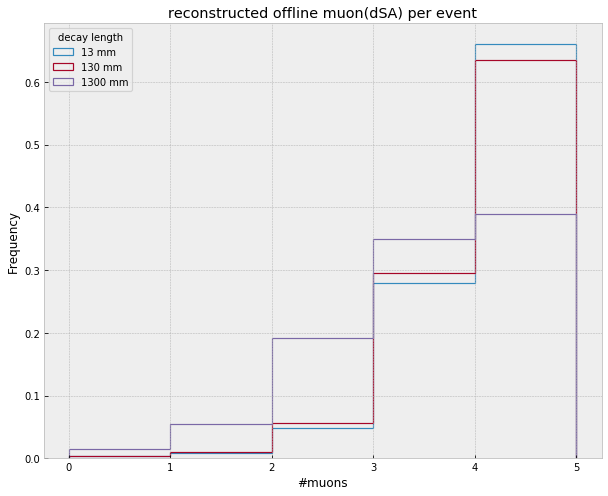

In [4]:
fig, ax = plt.subplots(figsize=(10,8))
plt.rcParams['patch.linewidth'] = 1.2

for k, df in dfs.items():
    df['nMatched'].plot.hist(bins=5, range=(0,5), ax=ax, label=f'{k} mm', histtype='step', density=True)
    print('%.2fmm #events: %i' % (k, len(df['nMatched'].dropna())))
ax.set_xlabel('#muons')
plt.title('reconstructed offline muon(dSA) per event')
plt.legend(loc='upper left', title='decay length')

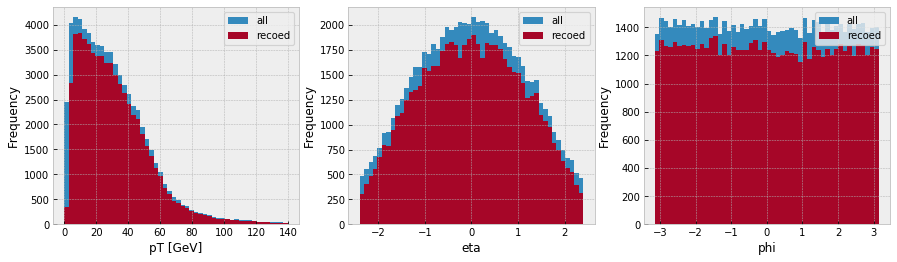

In [5]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

df = dfs[130]

recoDf = df[['genPt','genEta','genPhi', 'recoPt']].dropna()

df['genPt']    .plot.hist(bins=50, range=(0,140), ax=ax[0], label='all')
recoDf['genPt'].plot.hist(bins=50, range=(0,140), ax=ax[0], label='recoed')
ax[0].set_xlabel('pT [GeV]')

df['genEta']    .plot.hist(bins=50, range=(-2.4,2.4), ax=ax[1], label='all')
recoDf['genEta'].plot.hist(bins=50, range=(-2.4,2.4), ax=ax[1], label='recoed')
ax[1].set_xlabel('eta')

df['genPhi']    .plot.hist(bins=50, ax=ax[2], label='all')
recoDf['genPhi'].plot.hist(bins=50, ax=ax[2], label='recoed')
ax[2].set_xlabel('phi')

for a in ax: a.legend(loc='best')

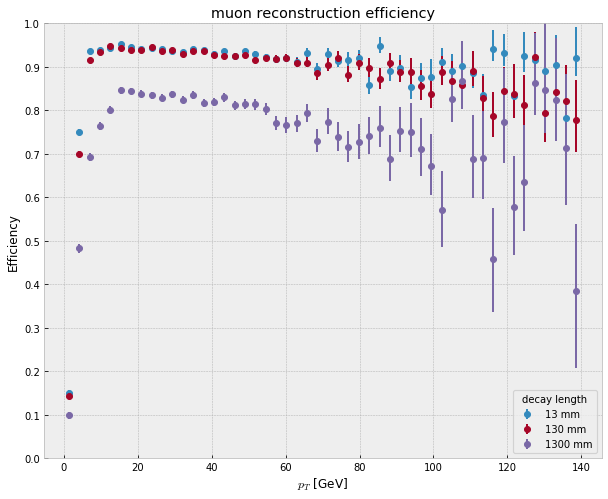

In [7]:

fig,ax = plt.subplots(figsize=(10,8))
# df = dfs[1]
for k, df in dfs.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    h0 = ROOT.TH1F(f'h0_{k}', '', 50,0,140)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50,0,140)
    for x in df['genPt']: h0.Fill(x)
    for x in recoDf['genPt']: h1.Fill(x)
    
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} mm')

ax.set_title('muon reconstruction efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

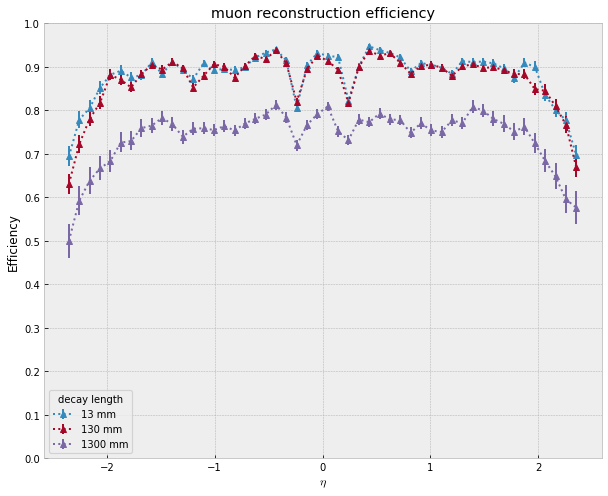

In [8]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs.items():
    recoDf = df[['genEta', 'recoEta']].dropna()
    h0 = ROOT.TH1F(f'h0_{k}', '', 50,-2.4,2.4)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50,-2.4,2.4)
    for x in df['genEta']: h0.Fill(x)
    for x in recoDf['genEta']: h1.Fill(x)
    
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} mm')

ax.set_title('muon reconstruction efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

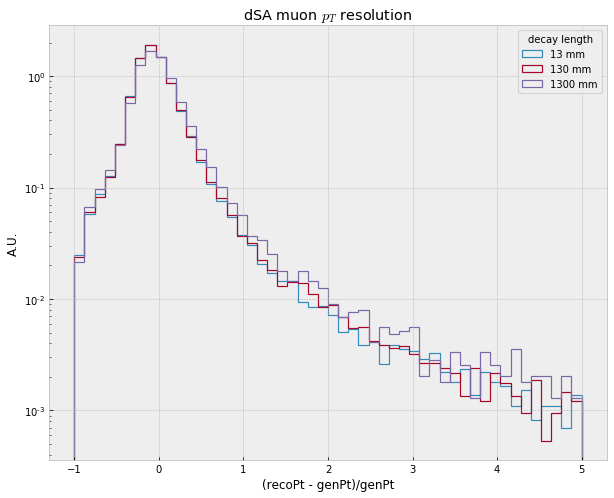

In [9]:
fig,ax = plt.subplots(figsize=(10,8))
# df = dfs[1]
for k, df in dfs.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    recoDf['reso'] = (recoDf['recoPt'] - recoDf['genPt']) / recoDf['genPt']
    recoDf['reso'].plot.hist(bins=50,range=(-1.,5), label=f'{k} mm', histtype='step',density=True)

ax.set_title('dSA muon $p_{T}$ resolution')
ax.set_xlabel('(recoPt - genPt)/genPt')
ax.set_ylabel('A.U.')
ax.set_yscale('log')
ax.legend(loc='best', title='decay length')

Warning in <TROOT::Append>: Replacing existing TH1: p_13 (Potential memory leak).


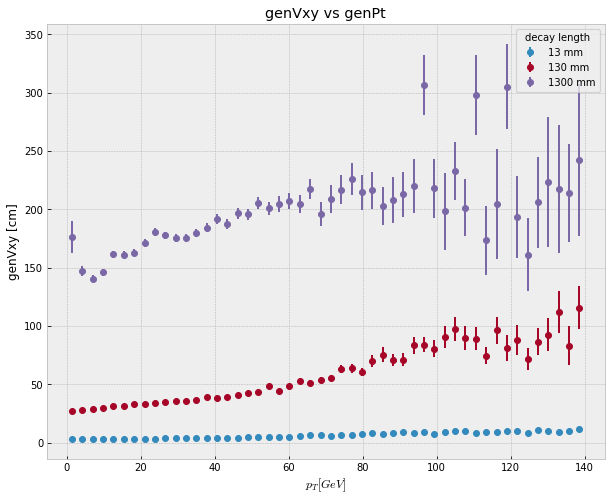

In [14]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs.items():
    recoDf = df[['genPt', 'genVxy', 'recoPt']].dropna()
    _p = ROOT.TProfile(f'p_{k}', '', 50,0,140,0,740)
    for index, row in recoDf.iterrows(): _p.Fill(row['genPt'], row['genVxy'])
    data = extract_tprof(_p)
    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], label=f'{k} mm', fmt='o')

ax.set_title('genVxy vs genPt')
ax.set_xlabel('$p_{T} [GeV]$')
ax.set_ylabel('genVxy [cm]')
ax.legend(loc='best', title='decay length')

(0, 1.0)

Warning in <TROOT::Append>: Replacing existing TH1: h0_ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1_ (Potential memory leak).


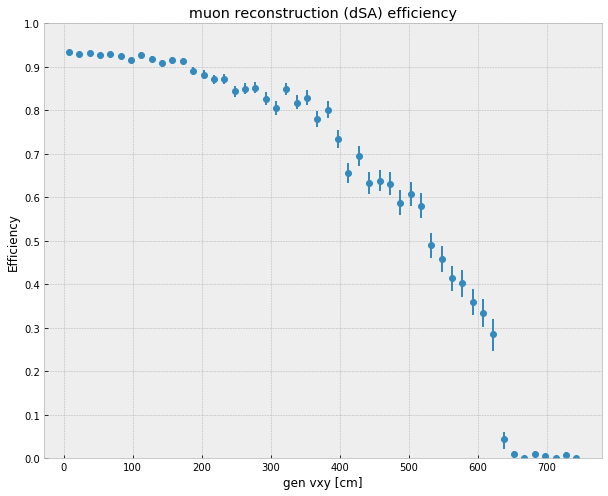

In [16]:
fig,ax = plt.subplots(figsize=(10,8))

h0 = ROOT.TH1F('h0_', '', 50,0,750)
h1 = ROOT.TH1F('h1_', '', 50,0,750)
for k, df in dfs.items():
    df = df.query('genPt>10 and abs(genEta)<2.4')
    recoDf = df[['genVxy', 'genPt', 'genEta', 'recoDxy']].dropna()

    for x in df['genVxy']: h0.Fill(x)
    for x in recoDf['genVxy']: h1.Fill(x)
    
eff = ROOT.TEfficiency(h1, h0)
data = extract_teffi(eff)

ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o')

ax.set_title('muon reconstruction (dSA) efficiency')
ax.set_xlabel('gen vxy [cm]')
ax.set_ylabel('Efficiency')
# ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1.0))